# What we are about to do...

This is an update from [Job Interview Project](https://github.com/sebastianperezv/Job-Interview-Project) but with LangGraph. With the Joke bot project we realize that LangGraph is very good at flows overall.
What we had at the Job Interview Project was a continious and a ciclycal flow. Now we are going to build it from scratch with better tools

# Setup

In [1]:
# Set OpenAI key in the environment
from google.colab import userdata
import os

api_key = userdata.get('genai_course')
os.environ['OPENAI_API_KEY'] = api_key

serper_api_key = userdata.get('serper_api')

In [2]:
!pip install -q langchain-community langchain-openai langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [3]:
!pip install -q grandalf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.8 MB/s eta 0:00:00


In [4]:
from openai import OpenAI

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.graph import START, StateGraph, END

from IPython.display import Markdown, Image
from typing_extensions import TypedDict

import json
import ast

In [5]:
# create openAI client
client = OpenAI()

In [6]:
COMPANY = '' # company that you are applying
LOCATION = 'CHI'
POSITION = 'Data Analytics Working Student'
BACKGROUND = [ # Add your background here
    "Former Senior Manager in Revenue Management and Analytics at Zalando",
    "Did Pro Bono at the UN",
    "Currently Founder of Data Heroes and Bitte",
]
INTERVIEWER = "Matthias Glöel" # only works for high-profile people

In [7]:
# Create a TypedDict Cass to store information
class AgentState(TypedDict):
  # Initial data
  company: str
  location: str # country, ISO Code
  position: str
  background: list[str]
  interviewer: str

  # Generated Content
  company_data: str
  interviewer_data: str
  questions: str

  # App keys
  memory: list

# Researching the company

Web Browsing with OpenAI: https://platform.openai.com/docs/guides/tools-web-search?api-mode=responses

Using the built-in tools from https://platform.openai.com/docs/api-reference/responses/create#responses_create-tools

WIP

In [ ]:
response = client.response.create(
    model = 'gpt-4.1',
    tools = [{'type': web_search_preview,
            'user_location': {
                'type': 'approximate',
                'country': LOCATION
              }
              }],
    input = f'Research about {COMPANY}'
)

In [ ]:
Markdown(response.output_text)

Create the function

In [8]:
# Researching about the company with OpenAI web search
def research_company(state):
  # Inputs for web search
  state['company'] = COMPANY
  state['location'] = LOCATION

  print('Researching Comapany---')
  response = client.responses.create(
      model = 'gpt-4.1',
      tools = [{'type': web_search_preview,
              'user_location': {
                  'type': 'approximate',
                  'country': state['location']
              }
              }],
      input = f'Research about {state['company']}'
  )

  # Store the outcome
  state['company_data'] = response.output_text
  display(Markdown(state['company_data']))
  return state

In [ ]:
# Test function
# See how it works
example_data = research_company({'company': COMPANY})

In [ ]:
example_data['company']

# Research the interviewer

In [9]:
# Build the function to research about the interviewer
def research_interviewer(state):
  # Inpouts for the web search
  state['company'] = COMPANY
  state['interviewer'] = INTERVIEWER
  state['location'] = LOCATION
  state['position'] = POSITION

  print('---Researching Inteviewer---')
  # Call the responses API
  response = client.responses.create(
      model = 'gpt-4.1',
      tools = [{'type': 'web_search_preview',
                'user_location': {
                    'type': 'approximate',
                    'country': state['location']
                },
                'search_context_size': 'medium'}],
      input = f'Research about {state['interviewer']}, who works for {state['company']} located in {state['location']}'
  )

  # update the AgentState
  state['interviewer_data'] = response.output_text

  # can display or not
  # display(Markdown(state['interviewer_data]))
  return state

In [ ]:
# Teste the research interviewer function
example_data_interviewer = research_interviewer(example_data)
example_data_interviewer['interviewer_data']

# Generate Questions

Generate Interview Questions - Part 1

WIP

In [ ]:
# Define system message por AI that generates questions
developer_message = f"""
You are an AI that generates Interview questions to help prepare the user.
Data:
Company name: {COMPANY}
Company report: {example_data['company_data']}
Interviewer_name: {INTERVIEWER}
Interviewer report: {example_data_interviewer[¿interviewer_data]}
Job Position: {POSITION}
User background: {BACKGROUND}

Output:
1) 10 consice question in bullet from to mimic a job interview.
2) Questions may touch upon the user's background, culture fit, job fit, or qhualifications
"""
print('---Generating Question---')
response = client.responses.create(
    model = 'gpt-4.1',
    input = [
        {'role': 'developer', 'content': developer_message},
    ]
)
questions = print(response.output_text)
questions

Generate Interview Questions - Part 2

Store in State

In [10]:
def generate_questions(state):
  state['background'] = BACKGROUND
  # Define system message for AI that generates questions
  developer_message = f"""
  You are an AI that generates Interview questions to help prepare the user.
  Data:
  Company name: {state['company']}
  Interviewer: {state['interviewer']}
  User Background: {state['background']}
  Job position: {state['position']}
  company_report from web search: {state['company_data']}
  Interviewer from web search: {state['interviewer_data']}

  Output:
  1) 10 consice question in bullet from to mimic a job interview.
  2) Questions may touch upon the user's background, culture fit, job fit, or qhualifications
  """
  print('---Generating Question---')
  response = client.responses.create(
      model = 'gpt-4.1',
      input = [
          {'role': 'developer', 'content': developer_message},
      ]
  )
  state['questions'] = print(response.output_text)
  return state

```
class AgentState(TypedDict):
  # Initial data
  company: str
  location: str # country, ISO Code
  position: str
  background: list[str]
  interviewer: str

  # Generated Content
  company_data: str
  interviewer_data: str
  questions: str
```



In [ ]:
# Test the generate questions function
example_data_questions = generate_questions({'interviewer_data': example_data_interviewer['interviewer_data'],
                                             'company': COMPANY,
                                             'background': BACKGROUND,
                                             'position': POSITION,
                                             'company_data': example_data['company_data'],
                                             'interviewer': INTERVIEWER})
display(Markdown(example_data_questions))

In [11]:
# Build the function for the interviewer bot
def interview_bot(state):
  if not state.get('memory'):
    state['memory'] = []

  developer_message = f"""
  You are an AI that helps prepare the user for job interview.
  Data:
  Company name: {state['comapny']}
  position: {state['position']}
  User background: {state['background']}

  You follow a pre-defined script.
  Ask the questions exactly as given, in order.
  After the answer of the user give actionable feedback tied to the role.

  Questions:
  {state['questions']}

  Memory: {state['memory']}
  """

  print('---Interviewing')
  response = client.response.create(
      model = 'gpt-4.1',
      input = [
          {'role': 'developer', 'content': developer_message}
      ]
  )

  question = respose.output_text
  display(Markdown(question))
  state['memory'].append(question)

  return state

In [12]:
# Build function to get an answer from the user
def get_answer(state):
  print('Please provide your answer')
  print('\n(Type "quit", "exit", "stop" or "end" to finish the practice)')
  user_input = input()
  state['memory'].append(f"User: {user_input}")
  state['terminate'] = user_input.lower().strip() in ['quit', 'exit', 'stop', 'end']

  return state

## Routers

In [13]:
# Function that decides to termina the flow or not
def termination_router(state):
  return 'End' if state.get('terminate') else 'Continue'

# Build Workflow

In [16]:
# Initializing the StateGraph
workflow = StateGraph(AgentState)

# Set the entry point for the workflow
workflow.set_entry_point('Research Company')

# Define Nodes
workflow.add_node('Research Company', research_company)
workflow.add_node('Research Interviewer', research_interviewer)
workflow.add_node('Generate Questions', generate_questions)
workflow.add_node('Interview Bot', interview_bot)
workflow.add_node('Get Answer', get_answer)

# Define Edges
workflow.add_edge('Research Company', 'Research Interviewer')
workflow.add_edge('Research Interviewer', 'Generate Questions')
workflow.add_edge('Generate Questions', 'Interview Bot')
workflow.add_edge('Interview Bot', 'Get Answer')

# Add a conditional edge for get_answer to go back or end the flow
workflow.add_conditional_edges(
    'Get Answer',
    termination_router,
    {
        'Continue': 'Interview Bot', # if Type Continue it goes to the interview_bot function
        'End': END
    }
)

# Compile the workflow
app = workflow.compile()

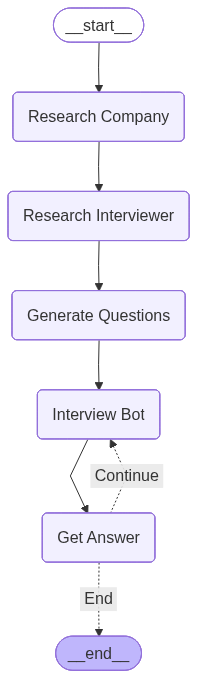

In [19]:
# Display the graph
display(Image(app.get_graph().draw_mermaid_png()))

In [18]:
# Incase you have issues with the image
app.get_graph().print_ascii()

      +-----------+      
      | __start__ |      
      +-----------+      
            *            
            *            
            *            
  +------------------+   
  | Research Company |   
  +------------------+   
            *            
            *            
            *            
+----------------------+ 
| Research Interviewer | 
+----------------------+ 
            *            
            *            
            *            
 +--------------------+  
 | Generate Questions |  
 +--------------------+  
            *            
            *            
            *            
    +---------------+    
    | Interview Bot |    
    +---------------+    
            *            
            *            
            *            
     +------------+      
     | Get Answer |      
     +------------+      
            .            
            .            
            .            
      +---------+        
      | __end__ |        
      +-----

In [ ]:
# test the app
result = app.invoke('recursion_limit': 50)